# ETL and Feature Engineering: Iteration 2.0

This script will do the same preprocessing as in the first itearation, but this time only with data from Sources 'MapQuest' and 'MapQuest-Bing'.

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
#Import cleaned dataset. It is the one that was exported with the script from last submission. 
df = pd.read_csv("US_Accidents_June20_CLEAN_Week1_Iteration2.0.csv")
df.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,...,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight,Year,Month,Weekday,Day,Hour,Minute,Duration
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,...,Night,Night,Night,2016,2,0,39,5,346.0,314.0
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,...,Night,Night,Day,2016,2,0,39,6,367.0,30.0
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,...,Night,Day,Day,2016,2,0,39,6,409.0,30.0
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,...,Day,Day,Day,2016,2,0,39,7,443.0,30.0
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,...,Day,Day,Day,2016,2,0,39,7,459.0,30.0


## Feature Engineering

As mentioned above, this script does the same feature engineering as in the first iteration, but to data only provenient from 2 of the 3 'Sources'. The output will only contain the features that are relevant for the training of the model. Also, those features will be already in shape to be fed to the prediction models, so one-hot encoding will also be performed. Irrelevant features will be deleted.

In [3]:
#Change all times to timestamps.Timestamp-data type.
df['Start_Time'] = pd.to_datetime(df.Start_Time, format='%Y-%m-%d %H:%M:%S')
df['End_Time'] = pd.to_datetime(df.End_Time, format='%Y-%m-%d %H:%M:%S')
df['Weather_Timestamp'] = pd.to_datetime(df.Weather_Timestamp, format='%Y-%m-%d %H:%M:%S')

### Irrelevant Features

All features that cannot be used as a predictor for the severity of the accident should be deleted. For that reason, all data that is gathered after the accident has taken place (i.e. 'End_Timestamp') and all data that has no relation to the accident (i.e. 'ID') will be deleted.

In [4]:
# Display columns
print('Number of features:', df.columns.shape[0])
print(df.columns)

Number of features: 56
Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Year', 'Month', 'Weekday', 'Day', 'Hour',
       'Minute', 'Duration'],
      dtype='object')


#### Drop ID and Source since not relevant for prediction

The accident ID is not relevant for predicting the severity, so it will be dropped. Also the Source is dropped here, since the imported csv has already data only from 'MapQuest' and 'MapQuest-Bing'.

In [5]:
print('Number of features before drop:', df.columns.shape[0])
df = df.drop(['ID', 'Source'], axis=1)
print('Number of features after drop:', df.columns.shape[0])

Number of features before drop: 56
Number of features after drop: 54


#### Drop TMC since it is defined after the accident

The TMC (Code that describes the accident) is of course not a valid predictor since it is defined after the accident takes place.

In [6]:
print('Number of features before drop:', df.columns.shape[0])
df = df.drop('TMC', axis=1)
print('Number of features after drop:', df.columns.shape[0])

Number of features before drop: 54
Number of features after drop: 53


#### Drop End_Time, Duration and Distance(mi)

In order to predict severity of the accident, we can of course not now how long it took since the two mayor factors that define the Severity level are Duration until traffic was cleared and Distance of the Accident!

In [7]:
print('Number of features before drop:', df.columns.shape[0])
df = df.drop(['End_Time', 'Duration', 'Distance(mi)'], axis=1)
print('Number of features after drop:', df.columns.shape[0])

Number of features before drop: 53
Number of features after drop: 50


#### Drop Description

Since the description of the accident is filled out after the accident happened, it cannot be used as a predictor!

In [8]:
# Drop column 'Description'
print('Number of features before drop:', df.columns.shape[0])
df = df.drop('Description', axis=1)
print('Number of features after drop:', df.columns.shape[0])

Number of features before drop: 50
Number of features after drop: 49


#### Drop Weather_Timestamp

Now that we have all the Timestamps in the same format, let's calculate the difference between last weather record and the time of the accident in order to see how up to date the weather records are.

In [9]:
#Calculate difference between Start_Time and Weather_Timestamp

weather_time_diff = df.Weather_Timestamp - df.Start_Time
#Transform to seconds
weather_time_diff = weather_time_diff.dt.total_seconds()
#Filter out biggest differences
weather_time_diff = weather_time_diff.sort_values(ascending=True)

#See how many of the Weather_Timestamps are more than one day away from the time of the accident. 
weather_bool_big_diff_vec = (weather_time_diff > 86400)|(weather_time_diff < -86400)
print('Number of Weather_Timestamps with more than 1 day difference wrt accident time:', weather_bool_big_diff_vec.sum())

Number of Weather_Timestamps with more than 1 day difference wrt accident time: 0


All of the Weather_Timestamps are within one day from the accident time, which is good. That means the Weather_Conditions are up to date and reflect the real weather at the time of the accident.

In [10]:
# Drop Weather_Timestamp
df = df.drop('Weather_Timestamp', axis=1)
print('Number of features after dropping Weather_Timestamp:', df.columns.shape[0])

Number of features after dropping Weather_Timestamp: 48


#### Deal with Sunset/Twilight

There are 4 Features that describe if at the time of the accident it was 'Day' or 'Night'. Since in my opinion the influence of this factor is mainly in the vision of the driver. I've read through the 4 descriptions and decided I'll only look at the Sunrise_Sunset feature, since it is the one that describes when the sun is in line with the horizont.

In [11]:
df = df.drop(columns=['Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight'])
print('Number of features after drop:', df.columns.shape[0])

Number of features after drop: 45


#### Deal with Country

All the data is from the USA, to this feature doesn't give any useful information. I'll drop the column.

In [12]:
#Drop 'Country'
df = df.drop('Country', axis=1)
print('Number of features after drop:', df.columns.shape[0])

Number of features after drop: 44


### Feature grouping

#### Weather Condition grouping

In [13]:
# Create a shorter list for 'Weather_Condition'

print('Unique Weather_Condtions:', df['Weather_Condition'].unique().shape)

Unique Weather_Condtions: (121,)


In [14]:
print('Unique Weather_Condtions list:', df['Weather_Condition'].unique())

Unique Weather_Condtions list: ['Light Rain' 'Overcast' 'Mostly Cloudy' 'Rain' 'Light Snow' 'Haze'
 'Scattered Clouds' 'Partly Cloudy' 'Clear' 'Snow'
 'Light Freezing Drizzle' 'Light Drizzle' 'Fog' 'Shallow Fog' 'Heavy Rain'
 'Light Freezing Rain' 'Cloudy' 'Drizzle' nan 'Light Rain Showers' 'Mist'
 'Smoke' 'Patches of Fog' 'Light Freezing Fog' 'Light Haze'
 'Light Thunderstorms and Rain' 'Thunderstorms and Rain' 'Fair'
 'Volcanic Ash' 'Blowing Sand' 'Blowing Dust / Windy' 'Widespread Dust'
 'Fair / Windy' 'Rain Showers' 'Mostly Cloudy / Windy'
 'Light Rain / Windy' 'Hail' 'Heavy Drizzle' 'Showers in the Vicinity'
 'Thunderstorm' 'Light Rain Shower' 'Light Rain with Thunder'
 'Partly Cloudy / Windy' 'Thunder in the Vicinity' 'T-Storm'
 'Heavy Thunderstorms and Rain' 'Thunder' 'Heavy T-Storm' 'Funnel Cloud'
 'Heavy T-Storm / Windy' 'Blowing Snow' 'Light Thunderstorms and Snow'
 'Heavy Snow' 'Low Drifting Snow' 'Light Ice Pellets' 'Ice Pellets'
 'Squalls' 'N/A Precipitation' 'Cloudy / Win

There are 128 unique weather conditions. After inspecting the weather conditions, I've decided to group them in 9 different groups after my judgement of similarity. This way I can get insights more easily. Also, this will be handy to see the feature importance when the model is created.

In [15]:
df['Clear'] = np.where(df['Weather_Condition'].str.contains('Clear|N/A Precipitation', case=False, na = False), 1, 0)
df['Cloudy'] = np.where(df['Weather_Condition'].str.contains('Cloud|Cloudy|Overcast', case=False, na = False), 1, 0)
df['Rain_Light'] = np.where(df['Weather_Condition'].str.contains('Rain|Storm|storm|Drizzle', case=False, na = False), 1, 0)
df['Rain_Heavy'] = np.where(df['Weather_Condition'].str.contains('Heavy Rain|Rain Shower|Heavy T-Storm|Heavy Thunderstorms|Thunder|Showers', case=False, na = False), 1, 0)
df['Snow_Light'] = np.where(df['Weather_Condition'].str.contains('Snow|Sleet|Ice', case=False, na = False), 1, 0)
df['Snow_Heavy'] = np.where(df['Weather_Condition'].str.contains('Heavy Snow|Heavy Sleet|Heavy Ice Pellets|Snow Showers|Squalls|Hail', case=False, na = False), 1, 0)
df['Fog'] = np.where(df['Weather_Condition'].str.contains('Fog|Haze', case=False, na = False), 1, 0)
df['Windy'] = np.where(df['Weather_Condition'].str.contains('Wind|Windy|Dust', case=False, na = False), 1, 0)
df['Sand/Ash'] = np.where(df['Weather_Condition'].str.contains('Sand|Ash', case=False, na = False), 1, 0)

print("Number of features:", df.columns.shape)
df.columns

Number of features: (53,)


Index(['Severity', 'Start_Time', 'Start_Lat', 'Start_Lng', 'End_Lat',
       'End_Lng', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Timezone', 'Airport_Code', 'Temperature(F)',
       'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)',
       'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset',
       'Year', 'Month', 'Weekday', 'Day', 'Hour', 'Minute', 'Clear', 'Cloudy',
       'Rain_Light', 'Rain_Heavy', 'Snow_Light', 'Snow_Heavy', 'Fog', 'Windy',
       'Sand/Ash'],
      dtype='object')

In [16]:
#Drop Weather_Condition column
df = df.drop(['Weather_Condition'], axis=1)
print('Number of features after drop:', df.columns.shape)

Number of features after drop: (52,)


#### Wind Direction grouping

In the begining I also wanted to group the wind directions as in the Weather Conditions, but after looking at a Wind Direction Rose I have decided to not group them, since there is no way of not biasing the groups, since wind directions like SWS can be grouped together with S or SW.

In [17]:
df['Wind_Direction'].unique()

array(['Calm', 'SW', 'SSW', 'WSW', 'WNW', 'NW', 'West', 'NNW', 'NNE',
       'South', 'North', 'Variable', 'SE', 'SSE', 'ESE', 'East', 'NE',
       'ENE', 'E', 'W', nan, 'S', 'VAR', 'CALM', 'N'], dtype=object)

There are though some wind directions that are the same and are written in different ways, so those will be grouped.

In [18]:
#Group Wind_Direction that are the same
df['Wind_Direction'].replace('Calm','CALM', inplace=True)
df['Wind_Direction'].replace('Variable','VAR', inplace=True)
df['Wind_Direction'].replace('South','S', inplace=True)
df['Wind_Direction'].replace('North','N', inplace=True)
df['Wind_Direction'].replace('East','E', inplace=True)
df['Wind_Direction'].replace('West','W', inplace=True)

### Missing Data

#### Imputting continous values

For the moment I'll only impute the float values with the median of that particular feature (more robust towards outliers than mean). For String features, a more detailed analysis should be done.

In [19]:
# I'll impute using the median value for that column.
#For computational efficiency reasons, I'll create a list with only the Features where NaN-values are present. So, I won't iterate through all Features to impute the NaNs.
nan_vec = ['Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)']

for element in nan_vec:
    df[element].fillna(df[element].median(), inplace=True)
    
print()
print(df.isnull().sum()/(df.shape[0])*100)


Severity               0.000000
Start_Time             0.000000
Start_Lat              0.000000
Start_Lng              0.000000
End_Lat              100.000000
End_Lng              100.000000
Number                60.336378
Street                 0.000000
Side                   0.000000
City                   0.002057
County                 0.000000
State                  0.000000
Zipcode                0.012506
Timezone               0.083144
Airport_Code           0.166975
Temperature(F)         0.000000
Wind_Chill(F)         58.076793
Humidity(%)            0.000000
Pressure(in)           0.000000
Visibility(mi)         0.000000
Wind_Direction         1.431045
Wind_Speed(mph)        0.000000
Precipitation(in)     62.308003
Amenity                0.000000
Bump                   0.000000
Crossing               0.000000
Give_Way               0.000000
Junction               0.000000
No_Exit                0.000000
Railway                0.000000
Roundabout             0.000000
Station

#### Drop columns with more than 50% NaNs

Dropping the data from Source 'Bing' has considerably changed the percentage of NaNs from several categories. I'll drop all categories with more than 50% of NaNs, since there is no point in imputing when there is such a big part of the data missing: <b>End_Lat</b>, <b>End_Lng</b>, <b>Number</b>, <b>Wind_Chill(F)</b>, <b>Precipitation(in)</b>.

In [20]:
df.drop(columns=['End_Lat', 'End_Lng', 'Number', 'Wind_Chill(F)', 'Precipitation(in)'], axis=1, inplace=True)

In [21]:
# Print the remaining NaNs
print(df.isnull().sum()/(df.shape[0])*100)

Severity           0.000000
Start_Time         0.000000
Start_Lat          0.000000
Start_Lng          0.000000
Street             0.000000
Side               0.000000
City               0.002057
County             0.000000
State              0.000000
Zipcode            0.012506
Timezone           0.083144
Airport_Code       0.166975
Temperature(F)     0.000000
Humidity(%)        0.000000
Pressure(in)       0.000000
Visibility(mi)     0.000000
Wind_Direction     1.431045
Wind_Speed(mph)    0.000000
Amenity            0.000000
Bump               0.000000
Crossing           0.000000
Give_Way           0.000000
Junction           0.000000
No_Exit            0.000000
Railway            0.000000
Roundabout         0.000000
Station            0.000000
Stop               0.000000
Traffic_Calming    0.000000
Traffic_Signal     0.000000
Turning_Loop       0.000000
Sunrise_Sunset     0.002178
Year               0.000000
Month              0.000000
Weekday            0.000000
Day                0

### Imputting categorical values

In [22]:
#For 'City' and 'Zipcode' we could take the most frequent city from the State in order to impute the value, but since the percentage of data missing is so small, I'll just drop those rows.
print('Shape before drop:', df.shape)
df = df.dropna(subset=['City', 'Zipcode'])
print('Shape after drop:', df.shape)

Shape before drop: (2478818, 47)
Shape after drop: (2478457, 47)


In [23]:
#For 'Airport_Code' I wouldn't know a realistic way of imputting withouth knowing the real location of the airports, so I'll drop the values.
print('Shape before drop:', df.shape)
df = df.dropna(subset=['Airport_Code'])
print('Shape after drop:', df.shape)

Shape before drop: (2478457, 47)
Shape after drop: (2474628, 47)


In [24]:
# For 'Timezone', 'Wind_Direction', 'Sunrise_Sunset' I'll also just drop the datapoints, since the amount of missing data is very small.
print('Shape before drop:', df.shape)
df = df.dropna(subset=['Timezone', 'Wind_Direction', 'Sunrise_Sunset'])
print('Shape after drop:', df.shape)

Shape before drop: (2474628, 47)
Shape after drop: (2443292, 47)


In [25]:
#print remaining missing values
print(df.isnull().sum()/(df.shape[0])*100)

Severity           0.0
Start_Time         0.0
Start_Lat          0.0
Start_Lng          0.0
Street             0.0
Side               0.0
City               0.0
County             0.0
State              0.0
Zipcode            0.0
Timezone           0.0
Airport_Code       0.0
Temperature(F)     0.0
Humidity(%)        0.0
Pressure(in)       0.0
Visibility(mi)     0.0
Wind_Direction     0.0
Wind_Speed(mph)    0.0
Amenity            0.0
Bump               0.0
Crossing           0.0
Give_Way           0.0
Junction           0.0
No_Exit            0.0
Railway            0.0
Roundabout         0.0
Station            0.0
Stop               0.0
Traffic_Calming    0.0
Traffic_Signal     0.0
Turning_Loop       0.0
Sunrise_Sunset     0.0
Year               0.0
Month              0.0
Weekday            0.0
Day                0.0
Hour               0.0
Minute             0.0
Clear              0.0
Cloudy             0.0
Rain_Light         0.0
Rain_Heavy         0.0
Snow_Light         0.0
Snow_Heavy 

## Encoding the data

### Time Encoding

In [26]:
print('Number of features before feature creation:', df.columns.shape[0])
#Year
df['Year'] = df['Start_Time'].dt.year

#Month
n_month = df['Start_Time'].dt.month
df['Month'] = n_month

#Weekday
df['Weekday']= df['Start_Time'].dt.weekday

#Day as number between 1-365
days_each_month = np.cumsum(np.array([0,31,28,31,30,31,30,31,31,30,31,30,31]))
nday = [days_each_month[arg-1] for arg in n_month.values]
nday = nday + df["Start_Time"].dt.day.values
df['Day'] = nday

#Hour
df['Hour'] = df['Start_Time'].dt.hour

#Minute
df['Minute']=df['Hour']*60.0+df["Start_Time"].dt.minute

print('Number of features after feature creation:', df.columns.shape[0])
print()

df.loc[:5, ['Year', 'Month', 'Weekday', 'Day', 'Hour', 'Minute']]

Number of features before feature creation: 47
Number of features after feature creation: 47



,Year,Month,Weekday,Day,Hour,Minute
0,2016,2,0,39,5,346.0
1,2016,2,0,39,6,367.0
2,2016,2,0,39,6,409.0
3,2016,2,0,39,7,443.0
4,2016,2,0,39,7,459.0
5,2016,2,0,39,7,464.0


In [27]:
#One Hot encode Year, Month, Weekday, Hour
print('Number of features before one-hot encoding:', df.columns.shape[0])
df = pd.get_dummies(df, columns=['Year', 'Month', 'Weekday', 'Hour'], drop_first=False)
print('Number of features after one-hot encoding:', df.columns.shape[0])

Number of features before one-hot encoding: 47
Number of features after one-hot encoding: 91


For <b>'Minute'</b>, the one-hot encoding would yield too many dimensions and we could fall into the curse of dimensionality. For that reason with categorical variables that have many different values, it makes sense to transform them into the frequency domain and then use that instead of the variable itself.

In [28]:
# Transform Minute into Minute_Freq
df['Minute_Freq'] = df.groupby(['Minute'])['Minute'].transform('count')
df['Minute_Freq'] = df['Minute_Freq']/df.shape[0]*24*60

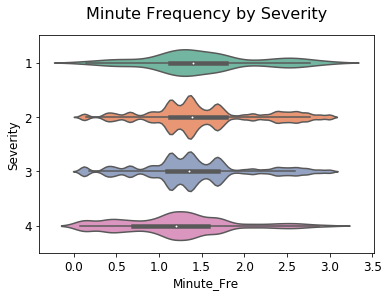

In [29]:
# Plot violin plot
df['Severity'] = df['Severity'].astype('category')
sns.violinplot(x='Minute_Freq', y="Severity", data=df, palette="Set2")    
plt.xlabel('Minute_Fre', size=12)
plt.ylabel('Severity', size=12)    
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.title('Minute Frequency by Severity', size=16, y=1.05)
plt.show()

There is no big difference, but there is a subtle decrease in frequency there higher the severity of the accident. WHat this means is that accidents with that happen less frequently have a higher probability of being more severe. Formulated another way: accidents that happen a lot are usually less severe that accidents that rarely happen.

In [30]:
#Drop 'Start_Time' and 'Minute'
print('Number of features before drop:', df.columns.shape[0])
df = df.drop(['Start_Time','Minute'], axis=1)
print('Number of features after drop:', df.columns.shape[0])

Number of features before drop: 92
Number of features after drop: 90


### Latitude and Longitude Encoding

Since they are continous values, no encoding needed.

### Street Encoding

Same dilemma as with Time. Since there are so many different streets, a one-hot encoding would lead to too many dimensions. Instead, a typical approach is to take the frequency of the value (in this case street name).

In [31]:
# Transform Street into Street_Freq
df['Street_Freq'] = df.groupby(['Street'])['Street'].transform('count')
df['Street_Freq'] = df['Street_Freq']/df['Street_Freq'].unique().shape[0]

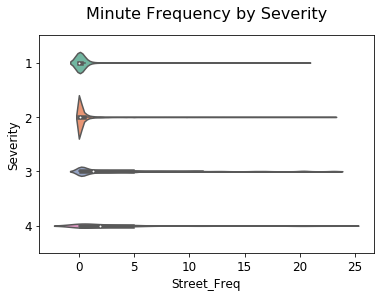

In [32]:
# Plot violin plot
df['Severity'] = df['Severity'].astype('category')
sns.violinplot(x='Street_Freq', y="Severity", data=df, palette="Set2")    
plt.xlabel('Street_Freq', size=12)
plt.ylabel('Severity', size=12)    
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.title('Minute Frequency by Severity', size=16, y=1.05)
plt.show()

In [33]:
#Drop 'Street', since I'll only use the Street_Freq
df.drop(columns='Street', inplace=True)

The plots have still a lot of skewness, so take the log of the distribution as in iteration1. 

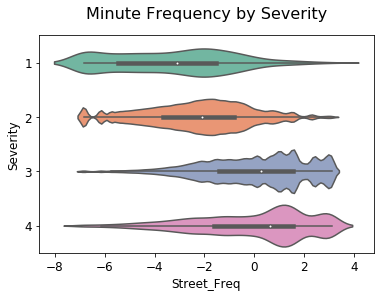

In [34]:
#Take log
df['Street_Freq'] = df['Street_Freq'].apply(lambda x: np.log(x))

# Plot again 
df['Severity'] = df['Severity'].astype('category')
sns.violinplot(x='Street_Freq', y="Severity", data=df, palette="Set2")    
plt.xlabel('Street_Freq', size=12)
plt.ylabel('Severity', size=12)    
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.title('Minute Frequency by Severity', size=16, y=1.05)
plt.show()

The plots here look very interesting! If I compre those to the same plots from iteration 1, the plots for severities 1-3 look the same, but for severity 4 the plot had the smallest frequency during iteration 1 nd now it has by far the highest frequency! I believe there is. different way of defining severity level between Source <b>MapQuest</b> and <b>Bing </b>. 

### Side

A basic one-hot encoding will be enough, since there are only 2 possible values. 

In [35]:
#Create one-hot encoding.
print('Number of features before one-hot encoding:', df.columns.shape[0])
df = pd.get_dummies(df, columns=['Side'])
print('Number of features after one-hot encoding:', df.columns.shape[0])

Number of features before one-hot encoding: 90
Number of features after one-hot encoding: 92


### Other Frequency Features: City, County, Zipcode, Airport_Code

Same as for 'Street', I'll use the frequency.

In [36]:
print('Number of features before frequency features creation:', df.columns.shape[0])

#City
df['City_Freq'] = df.groupby(['City'])['City'].transform('count')
df['City_Freq'] = df['City_Freq']/df.City.unique().shape[0]

#County
df['County_Freq'] = df.groupby(['County'])['County'].transform('count')
df['County_Freq'] = df['County_Freq']/df.County.unique().shape[0]

#Zipcode
df['Zipcode_Freq'] = df.groupby(['Zipcode'])['Zipcode'].transform('count')
df['Zipcode_Freq'] = df['Zipcode_Freq']/df.Zipcode.unique().shape[0]

#Airport_Code
df['Airport_Code_Freq'] = df.groupby(['Airport_Code'])['Airport_Code'].transform('count')
df['Airport_Code_Freq'] = df['Airport_Code_Freq']/df.Airport_Code.unique().shape[0]

print('Number of features after frequency features creation:', df.columns.shape[0])

Number of features before frequency features creation: 92
Number of features after frequency features creation: 96


In [37]:
#Drop columns with original variables
print('Number of features before drop:', df.columns.shape[0])

df = df.drop(columns=['City', 'County', 'Zipcode', 'Airport_Code'])

print('Number of features before drop:', df.columns.shape[0])

Number of features before drop: 96
Number of features before drop: 92


### Other features that will be one-hot enconded: 'Day', 'State', 'Timezone', 'Wind_Direction' and 'Sunrise_Sunset'

In [38]:
#Create one-hot encoding.
print('Number of features before one-hot encoding:', df.columns.shape[0])
df = pd.get_dummies(df, columns=['State', 'Timezone', 'Wind_Direction', 'Sunrise_Sunset'], drop_first=False)
print('Number of features after one-hot encoding:', df.columns.shape[0])

Number of features before one-hot encoding: 92
Number of features after one-hot encoding: 161


## Export

In [39]:
#Display names of columns
print(df.columns.shape)
df.columns

(161,)


Index(['Severity', 'Start_Lat', 'Start_Lng', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Amenity', 'Bump',
       ...
       'Wind_Direction_SE', 'Wind_Direction_SSE', 'Wind_Direction_SSW',
       'Wind_Direction_SW', 'Wind_Direction_VAR', 'Wind_Direction_W',
       'Wind_Direction_WNW', 'Wind_Direction_WSW', 'Sunrise_Sunset_Day',
       'Sunrise_Sunset_Night'],
      dtype='object', length=161)

In [40]:
#Save file with name as in convention explained
df.to_csv("US_Accidents_June20_CLEAN_Week2_Iteration2.0.csv", index=False)